In [1]:
# !pip install git+https://github.com/konstmish/opt_methods.git
# !pip install -U ray
# !pip install psutil
# !pip install seaborn
# !pip install numba

In [4]:
# Fundamental environment setup
import matplotlib
import numpy as np
import psutil
import ray
import seaborn as sns
import copy
import urllib.request
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.datasets import load_svmlight_file, fetch_rcv1

from optmethods.datasets import get_dataset
from optmethods.first_order import Adgd, Gd, Nesterov, RestNest
from optmethods.loss import LogisticRegression
from optmethods.utils import get_trace, relative_round

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [5]:
ray.shutdown()
num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus)

RayContext(dashboard_url='', python_version='3.8.12', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '10.68.186.178', 'raylet_ip_address': '10.68.186.178', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-26_16-04-33_063169_22334/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-26_16-04-33_063169_22334/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-26_16-04-33_063169_22334', 'metrics_export_port': 62884, 'gcs_address': '10.68.186.178:64595', 'address': '10.68.186.178:64595', 'node_id': 'c771ae912e49b6dafde560a00c1826510908de07f524fa629ab0f4bc'})

In [178]:
dataset = 'w8a'
n_workers = 10
regul = 1e-4
kappa = 10000
com_cost = 1
local_cost = 1000
bs = 64
# bs = 16

In [179]:
data_url = f"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{dataset}"
data_path = f"./{dataset}"
print(data_path)
# assert 0
f = urllib.request.urlretrieve(data_url, data_path)
# f = urllib.request.urlretrieve(a9a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

n, dim = A.shape  # \# of data and dimension for each data: 49749, 300
print(n, dim)
if n % num_cpus != 0:
    A = A[:n - (n % num_cpus)]
    b = b[:n - (n % num_cpus)]
b_unique = np.unique(b)
if (b_unique == [1, 2]).all():
    # Transform labels {1, 2} to {0, 1}
    b = b - 1
elif (b_unique == [-1, 1]).all():
    # Transform labels {-1, 1} to {0, 1}
    b = (b + 1) / 2
else:
    # replace class labels with 0's and 1's
    b = 1. * (b == b[0])
# A = A.toarray()
l1 = 0
loss = LogisticRegression(A, b, l1=l1, l2=0)
n, dim = A.shape
if n <= 20000 or dim <= 20000:
    print('Computing the smoothness constant via SVD, it may take a few minutes...')
# L = loss.smoothness
oL = loss.smoothness
m = int(n / n_workers)
L = loss.batch_smoothness(bs)
l2 = regul * L

./w8a
49749 300
Computing the smoothness constant via SVD, it may take a few minutes...


In [182]:
file_name = f'0019_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_cc1_kappa_kappa10000.0_error_1e-06.txt'
print(file_name)
# file_name = f'0019_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_cc1_kappa_kappa.0_error_1e-06.txt'
with open(f'./logs/{file_name}', 'r') as input:
    skip_it, vrskip_it = input.readline().split(',')
    skip_it, vrskip_it = int(skip_it), int(vrskip_it)
    print(skip_it, vrskip_it)
    skip_str = input.readline().split(',')
    vrskip_str = input.read().split(',')
    skip = [float(i) for i in skip_str]
    vrskip = [float(i) for i in vrskip_str]


# k1e3_w8a_err1e-6_real
# costs_real = [1e-9, 1e-8, 1e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2,
#                 3e-2, 6e-2, 1e-1, 3e-1, 6e-1, 1, 5, 1e1]
costs_real = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2,
                3e-2, 6e-2, 1e-1]
# k1e3_w8a_err1e-8_real
# costs_real_8 = [1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2, 3e-2, 6e-2, 1e-1, 3e-1, 6e-1, 1, 3, 6, 1e1, 1e2]

my_real_6 = []
for local_cost in costs_real:
    # Real cost
    skip_cost_real = com_cost * skip_it + np.sum(skip[:skip_it]) * local_cost * m
    vr_skip_cost_real = com_cost * vrskip_it + \
                        np.sum(vrskip[:vrskip_it]) * local_cost * bs
    my_real_6.append(float(skip_cost_real / vr_skip_cost_real))

0019_w8a_n10_bs64_cosize10_cc1_kappa_kappa10000.0_error_1e-06.txt
235 8460


In [183]:
# file_name = f'0019_w8a_n10_bs{bs}_cosize10_cc1_kappa_kappa1999.9999999999998_error_1e-08.txt'
file_name = f'0019_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_cc1_kappa_kappa10000.0_error_1e-08.txt'
# file_name = '0019_w8a_n10_bs32_cosize10_cc1_kappa_kappa10000.0_error_1e-08.txt'
# file_name = '0019_w8a_n20_bs16_cosize20_cc1_kappa_kappa10000.0_error_1e-08.txt'
# file_name = '0019_w8a_n10_bs16_cosize10_cc1_kappa_kappa1999.9999999999998_error_1e-08.txt'
with open(f'./logs/{file_name}', 'r') as input:
    skip_it, vrskip_it = input.readline().split(',')
    skip_it, vrskip_it = int(skip_it), int(vrskip_it)
    print(skip_it, vrskip_it)
    skip_str = input.readline().split(',')
    vrskip_str = input.read().split(',')
    skip = [float(i) for i in skip_str]
    vrskip = [float(i) for i in vrskip_str]

my_real_8 = []
for local_cost in costs_real:
    # Real cost
    skip_cost_real = com_cost * skip_it + np.sum(skip[:skip_it]) * local_cost * m
    vr_skip_cost_real = com_cost * vrskip_it + \
                        np.sum(vrskip[:vrskip_it]) * local_cost * bs
    my_real_8.append(float(skip_cost_real / vr_skip_cost_real))

387 6020


In [184]:
# file_name = f'0019_w8a_n10_bs{bs}_cosize10_cc1_kappa_kappa1999.9999999999998_error_1e-10.txt'
file_name = f'0019_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_cc1_kappa_kappa10000.0_error_1e-10.txt'
# file_name = '0019_w8a_n10_bs32_cosize10_cc1_kappa_kappa10000.0_error_1e-08.txt'
# file_name = '0019_w8a_n20_bs16_cosize20_cc1_kappa_kappa10000.0_error_1e-08.txt'
# file_name = '0019_w8a_n10_bs16_cosize10_cc1_kappa_kappa1999.9999999999998_error_1e-08.txt'
with open(f'./logs/{file_name}', 'r') as input:
    skip_it, vrskip_it = input.readline().split(',')
    skip_it, vrskip_it = int(skip_it), int(vrskip_it)
    print(skip_it, vrskip_it)
    skip_str = input.readline().split(',')
    vrskip_str = input.read().split(',')
    skip = [float(i) for i in skip_str]
    vrskip = [float(i) for i in vrskip_str]

my_real_10 = []
for local_cost in costs_real:
    # Real cost
    skip_cost_real = com_cost * skip_it + np.sum(skip[:skip_it]) * local_cost * m
    vr_skip_cost_real = com_cost * vrskip_it + \
                        np.sum(vrskip[:vrskip_it]) * local_cost * bs
    my_real_10.append(float(skip_cost_real / vr_skip_cost_real))

559 12942


In [185]:
A_dp = L
mu = l2
kappa = L / mu

c1 = np.array(costs_real)
p1 = np.sqrt(mu * oL) + m * oL * c1
p2 = np.sqrt(A_dp * mu) + (2 * m * mu + (2 * A_dp - 2 * mu) * bs) * c1
mfunc1 = p1 / p2
print(np.sqrt(oL/A_dp))

0.7768328879492564


/tmp/ipykernel_22334/3560927618.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


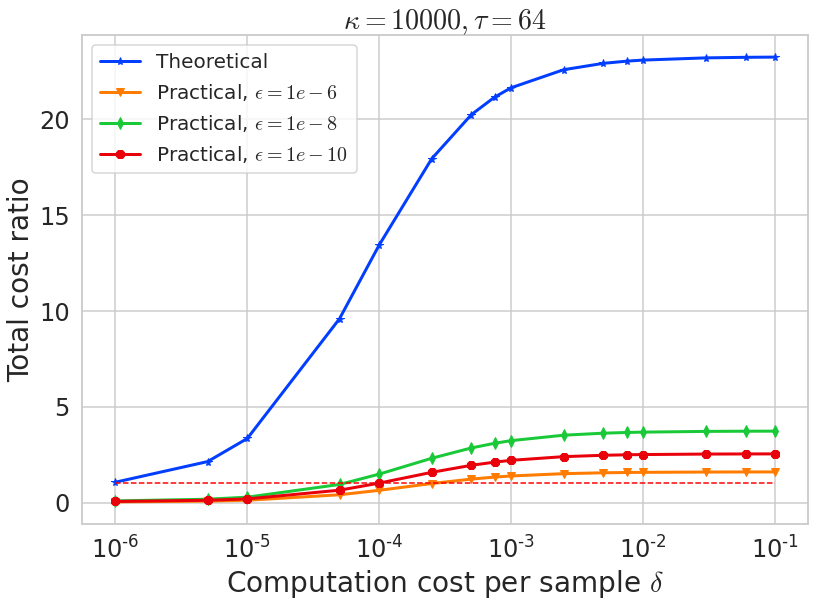

In [186]:
size = 30
markevery = 100
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 24  # 40
plt.rcParams['ytick.labelsize'] = 24  # 40
plt.rcParams['legend.fontsize'] = 20  # 30
plt.rcParams['axes.titlesize'] = 28  # 40
plt.rcParams['axes.labelsize'] = 28  # 40
plt.rcParams["figure.figsize"] = [13, 9]
plt.ylabel(r'Total cost ratio')
plt.xlabel(r'Computation cost per sample $\delta$')
# plt.yscale('log')
plt.xscale('log')
# plt.title(fr"$\kappa = {int(kappa)}, \tau={bs}$")
plt.title(fr"$\kappa = {10000}, \tau={bs}$")
# plt.legend()
plt.grid(b=True)

plt.plot(c1, mfunc1, marker='*', label=r"Theoretical", markersize=8)
# plt.plot(costs_real, my_real_4, marker='+', label=r'Practical, $\epsilon=1e-4$', markersize=8)
plt.plot(costs_real, my_real_6, marker='v', label=r'Practical, $\epsilon=1e-6$', markersize=8)
plt.plot(costs_real, my_real_8, marker='d', label=r'Practical, $\epsilon=1e-8$', markersize=8)
plt.plot(costs_real, np.ones(len(costs_real)), linestyle='--', c='red', linewidth=1.5)
plt.plot(costs_real, my_real_10, marker='8', label=r'Practical, $\epsilon=1e-10$', markersize=8)
plt.legend()
plt.savefig(f'{file_name}.pdf')
plt.show()
plt.close()